# **Data Analysis**
This notebook includes model prediction and analysis. This notebook uses user defined modules.

In [255]:
import pandas as pd
import seaborn as sns
import sys
import matplotlib.pyplot as plt

sys.path.append("../scripts")

# User defined modules
from data_cleaning import clean_data
import customer_classification
import customer_retention
import product_recommendation
import revenue_optimization

## **Get clean data**

In [256]:
df = customer_classification.get_analysis_data("../data/merged_data.csv")
df.head()

/home/sylvia/projects/sancom/bank-statements-cleaning/banks-env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (1,2,3,4,5,6,8,11,12,13,16,17,18,19,20,21,22,23,24,27,28,29,30,32,36,37,38,39,40,41,42,44,48,49,50,51,53,54,55,57,62,64,71,73,74,75,78) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,Customer ID,Is Blocked,Created At,Outstanding Amount,Loyalty Points,Number of Employees,Upload restuarant location,country_code,Order ID,Order Status,...,Task_Status,Rating,Review,Latitude,Longitude,Task_Details_QTY,Task_Details_AMOUNT,Special_Instructions,Subtotal,Payment_Type
0,3144837,0,2021-03-15T17:13:19.000Z,0.0,0,nan,NaN,254,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3174590,0,2021-03-20T14:15:11.000Z,0.0,0,nan,NaN,254,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3181998,0,2021-03-21T15:36:51.000Z,0.0,0,nan,NaN,254,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3191244,0,2021-03-23T08:54:00.000Z,367.0,367,nan,NaN,254,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3274222,0,2021-04-06T13:52:39.000Z,0.0,0,nan,NaN,254,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## **Customer Retention**
In this analysis I am checking whether a customer is likely to order again. To make this analysis I try to understand the customer purchase history. 

### Generate features from data
To predict whether a customer will make an order in February, I get the purchasing history of each customer. This involved:
Create Order column - this achieved by subtracting Total Cost Price from Total
Grouping data by Customer ID and:
1. Sum the Order Total, Consumed  Loyalty Points, Redeemed Loyalty Points 
2. Get min and max  of Order Time
3. Count Order ID per Customer ID
4. Get mean of latitude and longitude
   
Create Order Interval which is Order Time(max) - Order Time(min)
Create Average Order Interval which is Order Interval/Order ID(count)

These features become the input for the model.  The output of the column is whether the customer ordered in February or not based on their ordering habit in January.



In [257]:
# Define relevant columns 
customer_cols = ['Customer ID','Total Cost Price','Order Total', 'Sub Total', 'Tip', 'Discount',
        'Order ID', 'Redeemed Loyalty Points', 'Consumed Loyalty Points','Subtotal','Latitude','Longitude',
    'Number of Employees','Outstanding Amount','Loyalty Points','Rating',
    'Task_ID','country_code','Order Time']

# Define columns with monetary data
money_cols = ['Total Cost Price','Order Cost Total','Order Total',
                'Sub Total', 'Tip', 'Discount']

# Columns with generated columns
new_customer_cols = ['Customer ID','Order Cost Total','Order Total', 'Sub Total', 'Tip', 'Discount',
        'Order ID', 'Redeemed Loyalty Points', 'Consumed Loyalty Points','Subtotal','Latitude','Longitude',
    'Number of Employees','Outstanding Amount','Loyalty Points','Rating',
    'Task_ID','country_code','Order Time','gross_revenue','interval']

model_cols = ['Order Total', 'Avg Order Total', 'Order ID',
    'Redeemed Loyalty Points', 'Consumed Loyalty Points','Latitude','Longitude',
    'Avg Order Interval','Order Interval','repeat_customer']

x_cols = ['Order Total', 'Avg Order Total', 'Order ID',
    'Redeemed Loyalty Points', 'Consumed Loyalty Points',
    'Avg Order Interval','Order Interval']

# Split data before January is training set and February is testing data
january_df, after = customer_retention.split_data(df, customer_cols)

# Calculate new columns
january_df = customer_retention.generate_new_columns(january_df, money_cols)

january_df = january_df[new_customer_cols].drop_duplicates()

# Join data on Customer ID and aggregate other columns
customer_order_profile = customer_retention.aggregate_features(january_df)

# Get only customers that have made orders
purchasing_customers=customer_order_profile[customer_order_profile['Order ID']>0]

# Get output column
purchasing_customers = customer_retention.get_repeat_customers_column(purchasing_customers,after)

X = purchasing_customers[x_cols].values
y = purchasing_customers['repeat_customer'].values

purchasing_customers.head()

/home/sylvia/projects/sancom/bank-statements-cleaning/banks-env/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/home/sylvia/projects/data-scientist-assesment/notebooks/../scripts/customer_retention.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  purchasing_customers['repeat_customer'] = np.nan
/home/sylvia/projects/sancom/bank-statements-cleaning/banks-env/lib/python3.8/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be

,Customer ID,Order Total,Avg Order Total,gross_revenue,Order Time Max,Order Time Min,Order ID,Redeemed Loyalty Points,Consumed Loyalty Points,Task_ID,interval,Number of Employees,Latitude,Longitude,Outstanding Amount,Loyalty Points,country_code,Order Interval,Avg Order Interval,repeat_customer
32,3365770,67299.0,5176.846154,-42.40,2022-01-30 18:59:40+00:00,2022-01-17 13:47:02+00:00,13,1158.0,678.0,13,2.202851,nan,-1.287314,36.805498,55.0,55,254,13.217106,1.016700,0.0
40,3378262,98536.0,7038.285714,2031.14,2022-01-30 21:36:00+00:00,2022-01-05 18:09:32+00:00,14,498.0,809.0,13,3.591911,nan,-1.201032,36.900568,326.0,326,254,25.143380,1.795956,0.0
45,3385533,22406.0,2240.600000,350.78,2022-01-26 17:03:13+00:00,2022-01-07 15:06:16+00:00,10,351.0,222.0,9,3.816243,nan,-1.299200,36.890160,113.0,113,254,19.081215,1.908122,0.0
166,3636098,488758.0,9221.849057,29546.46,2022-01-31 21:54:34+00:00,2022-01-02 22:42:16+00:00,53,4977.0,4908.0,53,1.114111,5,-1.305033,36.817569,115.0,115,254,28.966875,0.546545,0.0
169,3647723,255380.0,5211.836735,7234.42,2022-01-30 20:21:35+00:00,2022-01-02 19:01:12+00:00,49,445.0,2533.0,49,1.168993,4,-1.190573,36.893340,1350.0,1350,254,28.055822,0.572568,0.0


### Show heatmap of generated features

<AxesSubplot:>

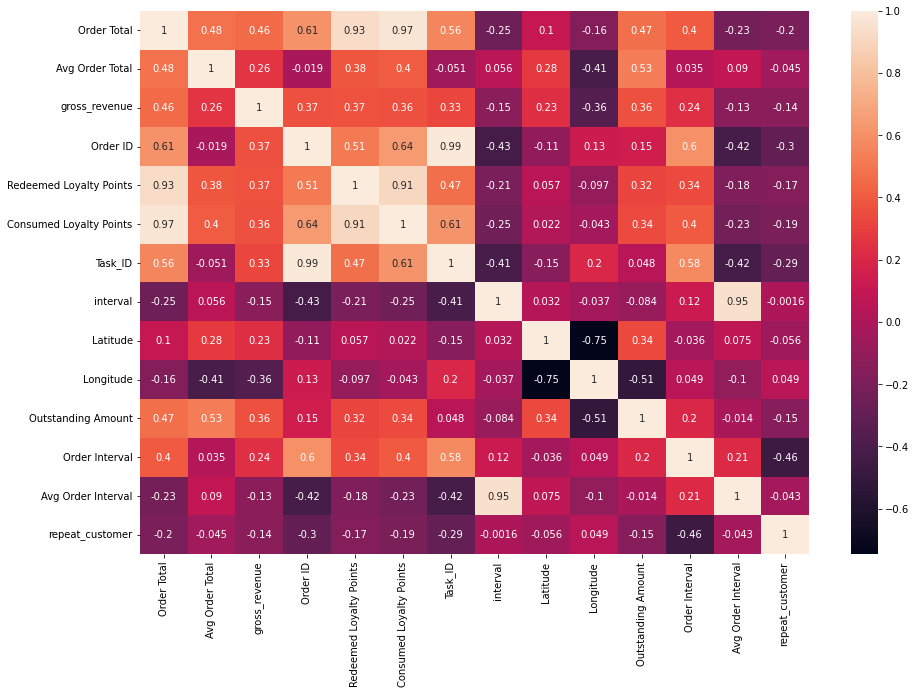

In [258]:
plt.rcParams["figure.figsize"] = (15,10)

# Get correlation of the generated features with each other
corr = purchasing_customers.corr()

#corr.to_csv("../data/purchasing_corr.csv")
sns.heatmap(corr, annot=True)


### Make Predictions

In [259]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

# Get array of generated data
X = purchasing_customers[x_cols].values
y = purchasing_customers['repeat_customer'].values
kf = KFold(n_splits=5)
kf.get_n_splits(X)

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    clf = LogisticRegression(random_state=0).fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    # Print accuracy of each fold
    print(accuracy_score(y_test, y_pred))
    

0.7619047619047619
0.7619047619047619
0.746031746031746
0.6984126984126984
0.7741935483870968


## **Customer Classification**
In this analysis I break down the different segments of customers. 

### **Get features**
Create Order column - this achieved by subtracting Total Cost Price from Total
Grouping data by Customer ID and:
1. Sum the Order Total, Consumed  Loyalty Points, Redeemed Loyalty Points 
2. Get min and max  of Order Time
3. Count Order ID per Customer ID
   
Create Order Interval which is Order Time(max) - Order Time(min)
Create Average Order Interval which is Order Interval/Order ID(count)
These features become the input for the model.  The output of the model is the class the customer belongs to.


In [260]:
# Define relevant columns 
customer_cols = ['Customer ID','Total Cost Price','Order Total', 'Sub Total', 'Tip', 'Discount',
        'Order ID', 'Redeemed Loyalty Points', 'Consumed Loyalty Points','Subtotal','Latitude','Longitude',
    'Number of Employees','Outstanding Amount','Loyalty Points','Rating',
    'Task_ID','country_code','Order Time']

# Define columns with monetary data
money_cols = ['Total Cost Price','Order Cost Total','Order Total',
                'Sub Total', 'Tip', 'Discount']

# Columns with generated columns
new_customer_cols = ['Customer ID','Order Cost Total','Order Total', 'Sub Total', 'Tip', 'Discount',
        'Order ID', 'Redeemed Loyalty Points', 'Consumed Loyalty Points','Subtotal','Latitude','Longitude',
    'Number of Employees','Outstanding Amount','Loyalty Points','Rating',
    'Task_ID','country_code','Order Time','gross_revenue','interval']

# Columns to be used in the model
model_cols = ['Order Total', 'Avg Order Total', 'gross_revenue',
        'Order ID','Redeemed Loyalty Points', 'Consumed Loyalty Points',
       'interval', 'Outstanding Amount', 'Loyalty Points', 'Order Interval',
       'Avg Order Interval']

# Generate columns from old data.
classes_df = customer_classification.generate_new_columns(df[customer_cols], money_cols)

classes_df = classes_df[new_customer_cols].drop_duplicates()

# Group by each Customer ID and aggregate other columns
customer_order_profile = customer_classification.aggregate_features(classes_df)

# Get customers that have made orders at least once
customer_purchase_history = customer_order_profile[customer_order_profile['Order ID']>0]

X_df = customer_purchase_history[model_cols].dropna(how='any').sample(frac=1)
X_df.head()

/home/sylvia/projects/data-scientist-assesment/notebooks/../scripts/customer_classification.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_df_before['interval'] = (customer_df_before.groupby('Customer ID')['Order Time'].diff().dt.total_seconds()/86400)*-1
/home/sylvia/projects/data-scientist-assesment/notebooks/../scripts/customer_classification.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_df_before['interval'] = customer_df_before['interval'].replace(0,np.nan)
/home/sylvia/p

,Order Total,Avg Order Total,gross_revenue,Order ID,Redeemed Loyalty Points,Consumed Loyalty Points,interval,Outstanding Amount,Loyalty Points,Order Interval,Avg Order Interval
5230,6316.0,2105.333333,-6657.16,3,0.0,63.0,7.056725,42.0,42,7.056725,2.352242
4243,47460.0,4746.000000,-29958.00,10,462.0,474.0,5.159093,128.0,128,25.795463,2.579546
4057,337770.0,84442.500000,26600.00,4,300.0,2505.0,7.146917,4554.0,4554.0,21.440752,5.360188
4676,242460.0,22041.818182,20380.00,11,830.0,1801.0,2.797690,1054.0,1054.0,27.976898,2.543354
2191,985851.0,30807.843750,-2076489.30,32,10359.0,9946.0,1.656861,384.0,384,26.509769,0.828430


#### **Get optimal classes**

In [261]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist


In [262]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)
 
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
 
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / X.shape[0])
    inertias.append(kmeanModel.inertia_)
 
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / X.shape[0]
    mapping2[k] = kmeanModel.inertia_

/tmp/ipykernel_7167/528822484.py:1: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bx-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(K, distortions, 'bx-', color='black')


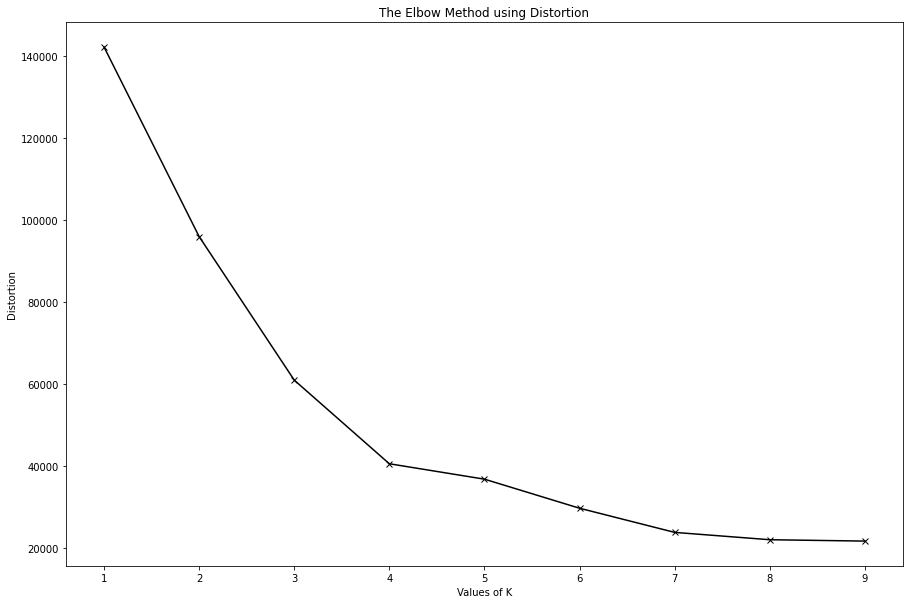

In [263]:
plt.plot(K, distortions, 'bx-', color='black')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

### **Fit model**

In [264]:
kmeans = KMeans(n_clusters=5, random_state=0).fit(X)
y=kmeans.predict(X)


### Reduce the number of features using PCA

/home/sylvia/projects/sancom/bank-statements-cleaning/banks-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

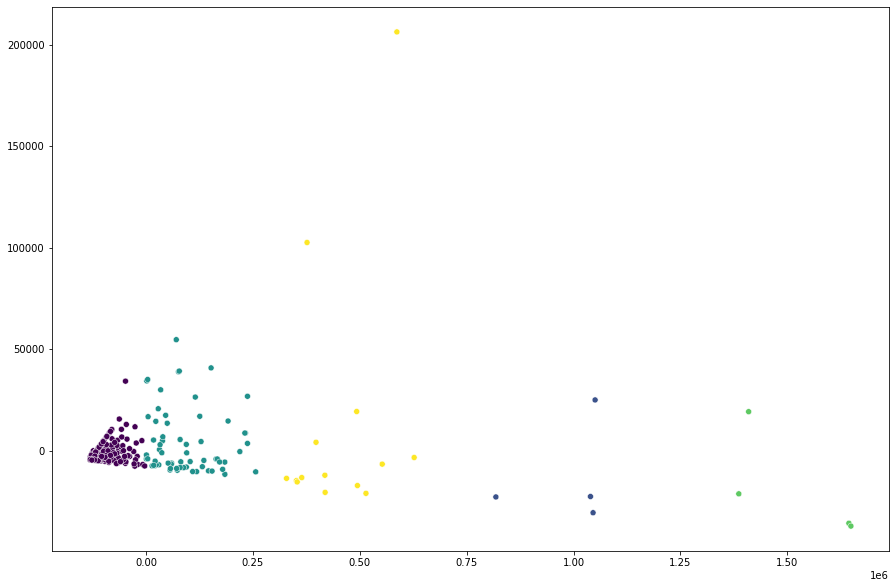

In [265]:
import numpy as np
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
features = pca.fit_transform(X)

sns.scatterplot(features[:,0], features[:,1],c=y)

# pca_df=pd.DataFrame(data=features)
# pca_df['classes']=y
#pca_df.to_csv("../data/pca_data.csv",index=False)

## **Recommendation System**

### Get features
1. Get the number of times a customer orders from a particular category of products.
2. Normalize the dataset so that the maximum number of orders per class is one.
3. Rescale by adding one so that now the minimum count is 1 and maximum is 2. This is because the Non-negative matrix factorization model does not accept zero.


In [266]:
recommendation_cols = ['Customer ID','Category Name']
recommendation_df = df[recommendation_cols].dropna()
recommendation_pivot = pd.pivot_table(data=recommendation_df,index='Customer ID',columns='Category Name',aggfunc=len,fill_value=0)
recommendation_pivot = (recommendation_pivot-recommendation_pivot.min())/(recommendation_pivot.max()-recommendation_pivot.min())+1
recommendation_data = recommendation_pivot.reset_index().melt(id_vars=['Customer ID'], var_name='Category Name', value_name='count')
recommendation_data.loc[recommendation_data['count']>1,'count']=2


### Split training and test set

In [267]:
X=recommendation_data.sample(frac=1)
X_train=X[:9000]
X_test = X[9000:]

### Fit model

In [268]:
from surprise import NMF, SVD, SVDpp, KNNBasic, KNNWithMeans, KNNWithZScore, CoClustering
from surprise import Reader, Dataset

algo = NMF()
data = Dataset.load_from_df(X_train,reader=Reader(rating_scale=(1, 2)))

algo.fit(data.build_full_trainset())
my_recs = []
d = {}
for uid,iid,rec in X_test.values:
    my_recs.append([uid,iid, algo.predict(uid=uid,iid=iid).est,rec])
    

### Transform predictions to meaningful predictions
Because there was no rating in the dataset, I interpreted the dataset in such a way that if the predicted value of the test set is greater than 1.5 then the customer is likely to purchase the product at least once otherwise no. This made it a classifier rather than a regression model.

In [269]:
pred_df = pd.DataFrame(my_recs,columns=['Customer ID','Category','predictions','true'])
pred_df['true_thresh']=1
pred_df['pred_thresh']=1
pred_df.loc[pred_df['true']>1,'true_thresh']=2
pred_df.loc[pred_df['predictions']>1.5,'pred_thresh']=2

pred_df.head()

,Customer ID,Category,predictions,true,true_thresh,pred_thresh
0,4878230,Flour & Sugar,1.388096,2.0,2,1
1,3676428,Fruits & Vegetables,1.073405,1.0,1,1
2,4577008,Cleaning & Hygiene,1.038634,1.0,1,1
3,4830671,Beer & Bitters,1.000000,1.0,1,1
4,4895684,Beer & Bitters,1.000000,1.0,1,1


### Get accuracy

In [270]:
from sklearn.metrics import r2_score
accuracy_score(pred_df['true'], pred_df['pred_thresh'])

0.8079710144927537

### **Revenue Optimization**

### Get data
Create Order column - this achieved by subtracting Total Cost Price from Total
Grouping data by Customer ID and:
1. Sum the Order Total, Consumed  Loyalty Points, Redeemed Loyalty Points 
2. Get min and max  of Order Time
3. Count Order ID per Customer ID
4. Get mean of latitude and longitude
   
Create Order Interval which is Order Time(max) - Order Time(min)
Create Average Order Interval which is Order Interval/Order ID(count)

/home/sylvia/projects/sancom/bank-statements-cleaning/banks-env/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


<AxesSubplot:>

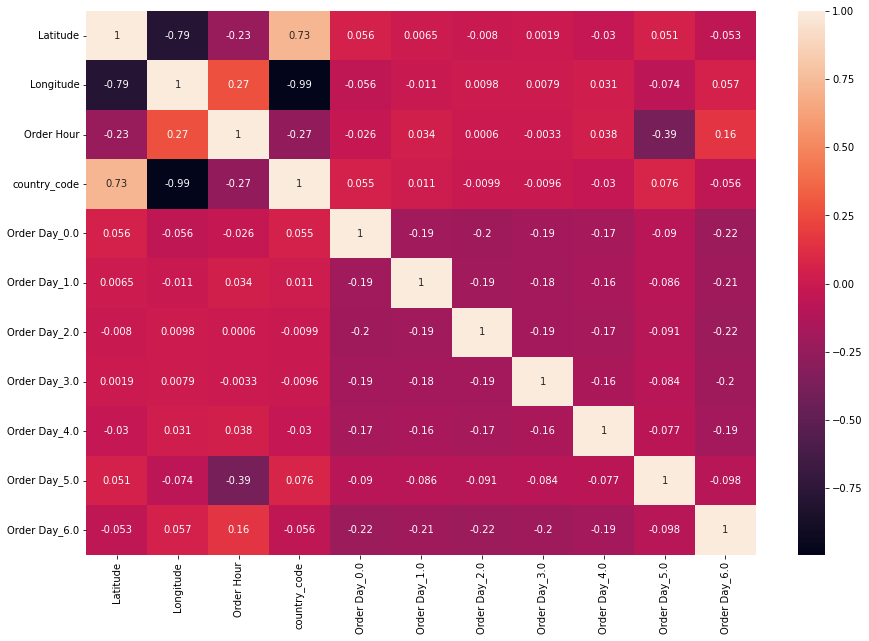

In [271]:
# Define relevant columns 
revenue_cols = ['Order ID','Latitude', 'Longitude','Category Name','Loyalty Points',
            'Order Time','Total Cost Price','Total Price','country_code','gross_revenue']

# Define columns to pass to model
x_cols=['Latitude', 'Longitude','Loyalty Points','Order Day','Order Hour',
            'country_code']

revenue_df = revenue_optimization.generate_new_columns(df, revenue_cols).dropna()

y=revenue_df['gross_revenue'].values

revenue_df = pd.get_dummies(revenue_df[x_cols],columns=['Order Day'])

# Get correlation of features
corr = revenue_df.corr()
sns.heatmap(corr,annot=True)

In [272]:
X = revenue_df.values

### Fit to model

In [273]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

revenue_df = revenue_df.sample(frac=1)
X = revenue_df.values
kf = KFold(n_splits=5)
kf.get_n_splits(X)

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    reg = LinearRegression().fit(X_train, y_train)
    y_pred = reg.predict(X_test)

    print(r2_score(y_test, y_pred))


-0.4019599846021411
-0.0021347664584052684
-0.0065135730185519325
-0.018020462984047025
-0.04799825465215868
